In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, SimpleRNN, Dense, Flatten, Lambda, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
from tensorflow.keras.backend import to_dense
import joblib
import re
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [ ]:
csv = 'Data/BE_All_Feeders__BE2B1__with_weather.csv'
csv2 = 'Data/TY_All_Feeders__TY2B10__with_weather.csv'
model = load_model("h6_model.keras")

In [3]:
def load_csv_file(csv):
    df = pd.read_csv(csv)
    df["Time"] = pd.to_datetime(df["Time"])
    df = df.set_index("Time").sort_index()
    df_resampled = df

    match = re.search(r'(?:Data/)?(.*?)__with_weather', csv)
    if match:
        extracted = match.group(1)  # Keep original code (e.g., TY2B10)
        print("Extracted code:", extracted)
    else:
        extracted = "Unknown"
        print("No match found.")

    return df, df_resampled, extracted


In [4]:
 df, df_resampled, extracted = load_csv_file(csv)

Extracted code: BE_All_Feeders__BE2B1


In [5]:
extracted

'BE_All_Feeders__BE2B1'

In [6]:
def plot_1(df_resampled,extracted):
    # Plot data
    fig = px.line(df_resampled, x=df_resampled.index, y='pv_kw', 
              title=f"Resampled {extracted} Over Time (1 hour Interval)",
          #    labels={"PowerCA": "Power (W)", "Time": "Timestamp"})
    )
    fig.show()

In [7]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length].values)
        y.append(data.iloc[i + seq_length].values)
    return np.array(X), np.array(y)

In [8]:
def data_sequence(df_resampled,seq_length):
    # Prepare data for modeling
    powdf = df_resampled[["pv_kw"]]
    # wdf = df_resampled.drop(columns="pv_kw")
    X1, y1 = create_sequences(powdf, seq_length)
    X1 = np.array(X1).squeeze(-1)
    print("X1 shape:", X1.shape)
    print("y1 shape:", y1.shape)

    # Prepare additional feature data
    features = ['temperature_2m (°C)', 'relative_humidity_2m (%)',
            'precipitation (mm)', 'cloud_cover (%)']
    X_features = df_resampled[features].iloc[:-1].values
    y_train = df_resampled['pv_kw'].iloc[1:].values.reshape(-1, 1)

    X_features = X_features[:5102, :]
    y_train = y_train[:5102, :]
    print("X_features shape:", X_features.shape)
    print("y_train:", y_train.shape)
    return X1, y1,X_features,y_train

In [9]:
def preprocess_data(X1, y1,X_features, y_train):
    # Split dataset
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle=False, random_state=42)
    # Scale data
    scaler_X = StandardScaler()
    X1_train_scaled = scaler_X.fit_transform(X1_train)
    X1_test_scaled = scaler_X.transform(X1_test)

    scaler_y = StandardScaler()
    y1_train_scaled = scaler_y.fit_transform(y1_train.reshape(-1, 1))
    y1_test_scaled = scaler_y.transform(y1_test.reshape(-1, 1))

    #additional features
    X_features_train, X_features_test, y_features_train, y_features_test = train_test_split(
    X_features, y_train, test_size=0.2, shuffle=False, random_state=42)

    # Scale additional features
    scaler_X_features = StandardScaler()
    X_features_train_scaled = scaler_X_features.fit_transform(X_features_train)
    X_features_test_scaled = scaler_X_features.transform(X_features_test)

    scaler_y_features = StandardScaler()
    y_features_train_scaled = scaler_y_features.fit_transform(y_features_train)
    y_features_test_scaled = scaler_y_features.transform(y_features_test)

    min_len = min(len(X1_test_scaled), len(X_features_test_scaled))

    X1_test_scaled = X1_test_scaled[:min_len]
    X_features_test_scaled = X_features_test_scaled[:min_len]
    y1_test_scaled = y1_test_scaled[:min_len]

    return (X1_train_scaled, X1_test_scaled, y1_train_scaled, y1_test_scaled,
        X_features_train_scaled, X_features_test_scaled, y_features_train_scaled, y_features_test_scaled,
        scaler_X, scaler_y, scaler_X_features, scaler_y_features)

# Model

In [10]:
#model = load_model("h6_model.keras")

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

def evaluate_model(model, X1_test_scaled, X_features_test_scaled, y1_test_scaled, scaler_y):
    # Predict
    predictions = model.predict([X1_test_scaled, X_features_test_scaled])
    predictions_original = scaler_y.inverse_transform(predictions)
    y_test_original = scaler_y.inverse_transform(y1_test_scaled.reshape(-1, 1))

    # Compute metrics
    mae = mean_absolute_error(y_test_original, predictions_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, predictions_original))
    mape = mean_absolute_percentage_error(y_test_original, predictions_original) * 100

    print("predictions shape:", predictions.shape)
    for i in range(min(5, len(predictions))):
        print(f"Predicted: {predictions_original[i][0]:,.2f}, Actual : {y_test_original[i][0]:,.2f}")

    return predictions, predictions_original, y_test_original, mae, rmse, mape


In [11]:
"""def evaluate_model2(model,X1_test_scaled, X_features_test_scaled,y1_test_scaled,scaler_y):
    # Evaluate model
    predictions = model.predict([X1_test_scaled, X_features_test_scaled])
    predictions_original = scaler_y.inverse_transform(predictions)
    y_test_original = scaler_y.inverse_transform(y1_test_scaled.reshape(-1, 1))
       
    print("predictions shape:", predictions.shape)
    for i in range(min(5, len(predictions))):
        print(f"Predicted: {predictions_original[i][0]:,.2f}, Actual : {y_test_original[i][0]:,.2f}")

    return predictions,predictions_original,y_test_original, mae, rmse, mape"""

In [12]:
"""test_results = model.evaluate([X1_test_scaled, X_features_test_scaled], y1_test_scaled)

# Check if test_results is a list and has more than one value
if isinstance(test_results, list):
    test_loss = test_results[0]  # First item is always loss
    test_mae = test_results[1] if len(test_results) > 1 else None  # Second item is MAE if it exists
    
    print(f'Test Loss: {test_loss:.2f}')
    if test_mae is not None:
        print(f'Test MAE: {test_mae:.2f}')
else:
    print(f'Test Loss: {test_results:.2f}')"""

"test_results = model.evaluate([X1_test_scaled, X_features_test_scaled], y1_test_scaled)\n\n# Check if test_results is a list and has more than one value\nif isinstance(test_results, list):\n    test_loss = test_results[0]  # First item is always loss\n    test_mae = test_results[1] if len(test_results) > 1 else None  # Second item is MAE if it exists\n    \n    print(f'Test Loss: {test_loss:.2f}')\n    if test_mae is not None:\n        print(f'Test MAE: {test_mae:.2f}')\nelse:\n    print(f'Test Loss: {test_results:.2f}')"

In [13]:
import pandas as pd
import numpy as np

def save_predictions_to_csv(df_resampled, y_test_original, predictions_original, output_path="testset_predictions.csv"):
    # Ensure y and predictions are 1D
    y_test_flat = y_test_original.flatten()
    preds_flat = predictions_original.flatten()

    # Align timestamps (assuming test set is from the end of the data)
    timestamps = df_resampled.index[-len(y_test_flat):]

    # Create a DataFrame
    results_df = pd.DataFrame({
        "Timestamp": timestamps,
        "Actual": y_test_flat,
        "Predicted": preds_flat
    })

    # Save to CSV
    results_df.to_csv(output_path, index=False)
    print(f"Saved predictions to {output_path}")

    return results_df

In [14]:
import numpy as np
print("Weight Sum:", np.sum(model.get_weights()[0]))


Weight Sum: -0.46221274


# pipe

In [15]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import tensorflow as tf

def full_forecasting_pipeline(
    model, df_resampled, scaler_X, scaler_y,
    y_test_original, predictions_original,
    start_time="2024-07-31 00:00:00",
    end_time="2024-07-31 23:00:00",
    seq_length=10,
    test_limit=998,
    output_csv="plot_csv/full_test_future_data.csv",
    output_html="FuturePvsA_total.html"
):
    @tf.function
    def predict_load(load_seq, add_feat):
        return model([load_seq, add_feat])

    start_time = pd.Timestamp(start_time)
    end_time = pd.Timestamp(end_time)
    prediction_times = pd.date_range(start=start_time, end=end_time, freq='h')

    # Extend index to include prediction range
    all_times = pd.date_range(df_resampled.index.min(), end_time, freq='h')
    df_resampled = df_resampled.reindex(all_times).ffill()

    features = ['temperature_2m (°C)', 'relative_humidity_2m (%)',
                'precipitation (mm)', 'cloud_cover (%)']

    predictions = []
    for target_timestamp in prediction_times:
        history_start = target_timestamp - pd.Timedelta(hours=seq_length)
        history_end = target_timestamp - pd.Timedelta(hours=1)
        history_df = df_resampled.loc[history_start:history_end]

        if len(history_df) < seq_length:
            print(f"Not enough historical data for prediction at {target_timestamp}. Skipping.")
            continue

        load_sequence = history_df["pv_kw"].values
        load_sequence_scaled = scaler_X.transform(load_sequence.reshape(1, -1)).reshape(1, seq_length, 1)

        if target_timestamp in df_resampled.index:
            additional_features = df_resampled.loc[target_timestamp, features].values.reshape(1, -1)
        else:
            nearest_idx = df_resampled.index.get_indexer([target_timestamp], method='nearest')[0]
            nearest_timestamp = df_resampled.index[nearest_idx]
            print(f"Target timestamp {target_timestamp} not found. Using nearest {nearest_timestamp} for features.")
            additional_features = df_resampled.loc[nearest_timestamp, features].values.reshape(1, -1)

        pred_scaled = predict_load(load_sequence_scaled, additional_features)
        pred_scaled = pred_scaled.numpy()
        predicted_value = scaler_y.inverse_transform(pred_scaled)[0][0]
        predictions.append((target_timestamp, predicted_value))

    # Unpack predictions
    future_times, future_preds = zip(*predictions)

    # Build and save DataFrame
    actual_full_cut = df_resampled['pv_kw'][:5089]
    test_time_index = df_resampled.index[-test_limit:]
    all_timestamps = list(actual_full_cut.index) + list(future_times)

    df_plot = pd.DataFrame({
        "Timestamp": all_timestamps,
        "Actual_Full": list(actual_full_cut) + [np.nan] * len(future_times),
        "Actual_Test": [np.nan] * (len(actual_full_cut) - test_limit) +
                       list(y_test_original[:test_limit].flatten()) +
                       [np.nan] * len(future_times),
        "Predicted_Test": [np.nan] * (len(actual_full_cut) - test_limit) +
                          list(predictions_original[:test_limit].flatten()) +
                          [np.nan] * len(future_times),
        "Predicted_Future": [np.nan] * len(actual_full_cut) + list(future_preds),
        "Predicted_Extended": [np.nan] * (len(actual_full_cut) - test_limit) +
                              list(predictions_original[:test_limit].flatten()) +
                              list(future_preds)
    })

    df_plot.to_csv(output_csv, index=False)
    print(f"Saved full test + future prediction data to: {output_csv}")

    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_plot["Timestamp"], y=df_plot["Actual_Full"], mode='lines',
                             name='Full Actual Data', line=dict(dash='dot', color='gray')))
    fig.add_trace(go.Scatter(x=df_plot["Timestamp"], y=df_plot["Actual_Test"], mode='lines',
                             name='Actual (Test Set)', line=dict(dash='dash', color='blue')))
    fig.add_trace(go.Scatter(x=df_plot["Timestamp"], y=df_plot["Predicted_Test"], mode='lines',
                             name='Predicted (Test Set)', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=df_plot["Timestamp"], y=df_plot["Predicted_Future"], mode='lines+markers',
                             name='Future 24H Predictions', line=dict(color='green'),
                             marker=dict(symbol='circle', size=6)))
    fig.update_layout(
        title="Predicted vs. Actual Values Over Time (Including Future 24H Forecast)",
        xaxis_title="Time",
        yaxis_title="Power Output (Original Scale)",
        xaxis=dict(tickformat="%Y-%m-%d %H:%M"),
        legend=dict(x=0, y=1),
        template="plotly_white",
        hovermode='x unified'
    )
    fig.show()
    # Optionally save HTML
    # fig.write_html(output_html)
    # print(f"Saved interactive plot to: {output_html}")

    return df_plot


In [16]:
df,df_resampled,extracted = load_csv_file(csv)  ##1

Extracted code: BE_All_Feeders__BE2B1


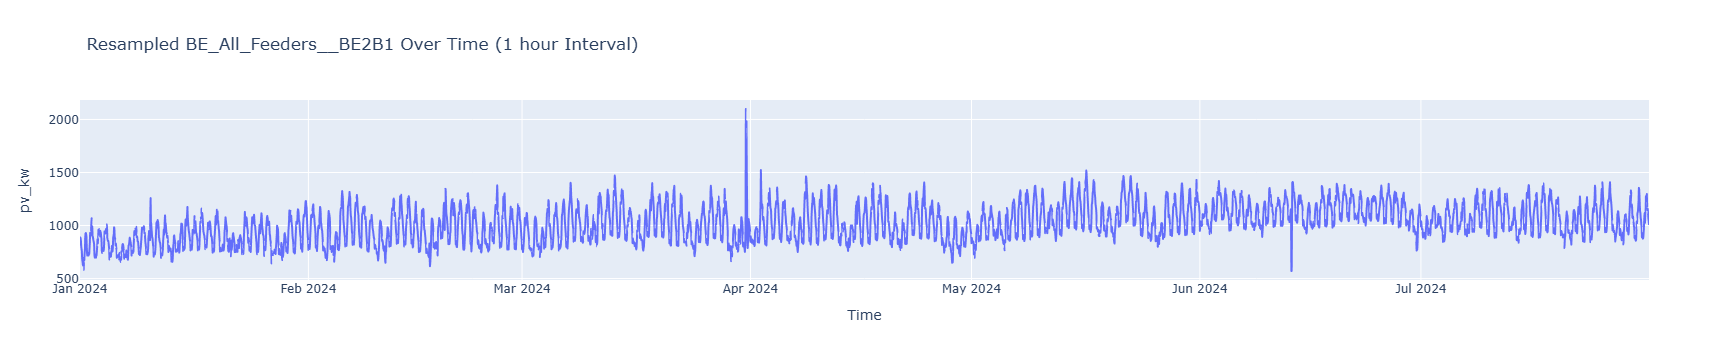

In [17]:
plot_1(df_resampled,extracted)  ##2

In [18]:
X1, y1,X_features,y_train = data_sequence(df_resampled,10) ##3

X1 shape: (5102, 10)
y1 shape: (5102, 1)
X_features shape: (5102, 4)
y_train: (5102, 1)


In [19]:
(X1_train_scaled, X1_test_scaled, y1_train_scaled, y1_test_scaled,
 X_features_train_scaled, X_features_test_scaled, y_features_train_scaled, y_features_test_scaled,
 scaler_X, scaler_y, scaler_X_features, scaler_y_features) = preprocess_data(X1, y1, X_features, y_train)  ##4

In [25]:
(predictions,predictions_original,y_test_original,mae, rmse, mape) = evaluate_model(model,X1_test_scaled, X_features_test_scaled,y1_test_scaled,scaler_y)  ##5

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
predictions shape: (1021, 1)
Predicted: 1,200.08, Actual : 1,280.74
Predicted: 1,232.81, Actual : 1,237.46
Predicted: 1,180.68, Actual : 1,309.72
Predicted: 1,302.64, Actual : 1,394.01
Predicted: 1,351.64, Actual : 1,378.32


In [26]:
mae, rmse, mape

(44.23884087244048, np.float64(57.25319802987374), 4.037150425042585)

In [83]:
save_predictions_to_csv(df_resampled, y_test_original, predictions_original, output_path="plot_csv/testset_predictions.csv")  ##6

Saved predictions to plot_csv/testset_predictions.csv


,Timestamp,Actual,Predicted
0,2024-06-19 11:00:00,1280.74,1200.075928
1,2024-06-19 12:00:00,1237.46,1232.810059
2,2024-06-19 13:00:00,1309.72,1180.675171
3,2024-06-19 14:00:00,1394.01,1302.643188
4,2024-06-19 15:00:00,1378.32,1351.640137
...,...,...,...
1016,2024-07-31 19:00:00,1156.36,1127.454102
1017,2024-07-31 20:00:00,1110.92,1179.299683
1018,2024-07-31 21:00:00,1067.78,1149.853394
1019,2024-07-31 22:00:00,1041.08,1061.959351


Saved full test + future prediction data to: plot_csv/full_test_future_data.csv


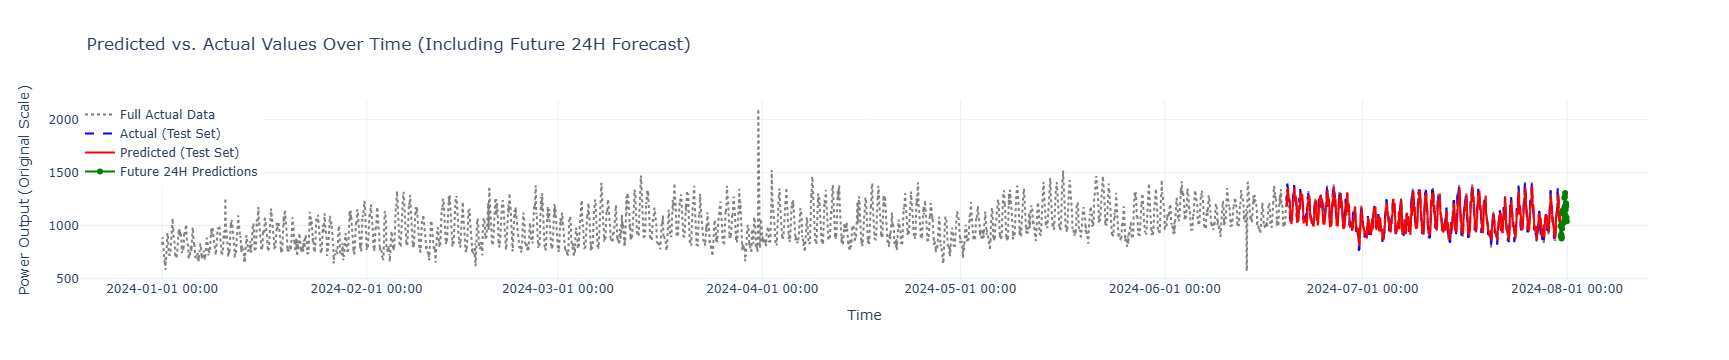

In [84]:
df_plot = full_forecasting_pipeline(
    model=model,
    df_resampled=df_resampled,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    y_test_original=y_test_original,
    predictions_original=predictions_original
) ## 7


In [1]:
def run_load_model(csv='Data/TY_All_Feeders__TY2B10__with_weather.csv',model="h6_model.keras"):
    df,df_resampled, extracted = load_csv_file(csv)  ##1 
    plot_1(df_resampled,extracted)  ##2
    X1, y1,X_features,y_train = data_sequence(df_resampled,10) ##3
    (X1_train_scaled, X1_test_scaled, y1_train_scaled, y1_test_scaled,
    X_features_train_scaled, X_features_test_scaled, y_features_train_scaled, y_features_test_scaled,
    scaler_X, scaler_y, scaler_X_features, scaler_y_features) = preprocess_data(X1, y1, X_features, y_train)  ##4
    (predictions,predictions_original,y_test_original, mae, rmse, mape) = evaluate_model(model,X1_test_scaled, X_features_test_scaled,y1_test_scaled,scaler_y)  ##5
    save_predictions_to_csv(df_resampled, y_test_original, predictions_original, output_path="plot_csv/testset_predictions.csv")  ##6
    df_plot = full_forecasting_pipeline(
    model=model,
    df_resampled=df_resampled,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    y_test_original=y_test_original,
    predictions_original=predictions_original
    ) ## 7
    return df_plot, extracted,mae, rmse, mape
